# Capstone Project Summary 

2020-08-14

## 1. Introduction/Business Problem

### 1.1 Discover which neighborhood in Melhourne is the best for young families

<br>

Melbourne, one of the most populous cities in Australia, attracted nearly 1 million people to move into since 2001. 

Lots of newcomers to Melbourne are highly interested in what the city has to offer, and especially what venues and facilities are in each neighborhood. 
Without having enough information on each neighborhood, it would be a difficult problem for them to decide where to live.

So this project is here for those people with young family who are looking to move into Melbourne and want to find out the neighborhood that fit them the best. The project will help the target audiences by providing the relevant information on each neighborhood visually on the map. The project will analysis each neighborhood on the venues and facilities it has, with main focus on the ease of accessing grocery stores, school, drug stores, cafes, malls, hospitals, etc, all of which are accessible from Foursquare location data.



### 1.2  Target Audience

1. Business professional around the world who wants to move into Melbourne. This analysis will be a comprehensive guide to choose where to live in Melbourne
     
2. Local residents in Melbourne who wish to get to know their city better.
     
3. Travellers, freelancers, bloggers, and influencers who wants to get to know the City of Melbourne for their next vacation. 

4. Data scientists, who wish to analyze the neighborhoods of Melbourne using Exploratory Data Analysis and other statistical & machine learning techniques to obtain all the necessary data, perform some operations on it and, tell a story out of it.


## 2. Data

### 2.1 Data Sources

Foursquare API (https://developer.foursquare.com/docs) will be used to obtain information for each venue:  
    
    - Name: The name of the venue.
    - Category: The category type as defined by the API.
    - Latitude: The latitude value of the venue.
    - Longitude: The longitude value of the venue.


From this website (https://download.geonames.org/export/zip/), I was able to download a tab-delimited text in utf8 encoding, with the following fields : 

    - country code: AU for Australia.
    - postal code: 4 digit postal code
    - place name: neighborhood name
    - admin name1: province
    - admin code1: province code
    - admin name2: city
    - admin code2: order subdivision (county/province) varchar(20)
    - admin name3: order subdivision (community) varchar(100)
    - admin code3: order subdivision (community) varchar(20)
    - latitude: estimated latitude (wgs84)
    - longitude: estimated longitude (wgs84)
    - accuracy: accuracy of lat/lng from 1=estimated, 4=geonameid, 6=centroid of addresses or shape


From this website (https://postal-codes.cybo.com/australia/melbourne/#listcodess), I was able to extract the list of suburbs within Melbourne

    - Postal Code	
    - City	
    - Administrative Region	
    - Population	
    - Area
    
### 2.2 Data cleaning


In [382]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import random # library for random number generation
import bs4 as bs # Library for web scripting
import urllib.request # Library for web scripting
from IPython.display import Image # libraries for displaying images
from IPython.core.display import HTML 
from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library
import folium # plotting library
import lxml
from sklearn.cluster import KMeans 
print('Libraries imported.')

Libraries imported.


#### 2.2.1: Collect data on all neighborhood and its geography coordinates


In [385]:
# Import all postal codes with latitude and longtitue for Australia.
postalcode = pd.read_csv("https://raw.githubusercontent.com/Serenacancode/Coursera_Capstone/master/data_sources/AU.txt", sep='\t', lineterminator='\n', header=None)
postalcode.columns=["country code","postal code", "place name", "province","province2","city","county/province2","community","community2",
                    "Latitude","Longitude","accuracy"]

# filter out only the postal code in victorica
postalcode=postalcode[postalcode['province']== "Victoria"]

# drop the irrelevent columns
postalcode.drop(columns=["country code", "province","province2","city","county/province2","community","community2","accuracy"],inplace=True)

# set postal code to be the index
postalcode.set_index("postal code",inplace=True)
postalcode.head()

,place name,Latitude,Longitude
postal code,,,
3000,Melbourne,-37.8130,144.9611
3001,Melbourne,-37.8140,144.9633
3002,East Melbourne,-37.8133,144.9839
3003,West Melbourne,-37.8088,144.9473
3004,Melbourne,-37.8422,144.9762


In [386]:
postalcode.shape

(3260, 3)

So we have 3260 results for all postal code in Australia.

In [387]:
# Import all Postal Codes in Melbourne 
source = urllib.request.urlopen('https://postal-codes.cybo.com/australia/melbourne/#listcodes').read()
soup = bs.BeautifulSoup(source,'lxml') 
mel = pd.read_html(str(soup.find_all('table')))[1]

# drop irrelevent columns
mel.drop(columns=["City","Administrative Region","Population","Area"],inplace=True) 

In [388]:
mel.head()

,Postal Code
0,3000
1,3001
2,3004
3,3010
4,3050


There are 31 postal codes in Melbourne. We are only interested in them.

In [389]:
# Merge the two dataframe to compile all the neighborhood in Melbourne with corresponding latitude and longtitude
df=pd.merge(mel,postalcode,left_on='Postal Code',right_on="postal code", how='left')
df.head()

,Postal Code,place name,Latitude,Longitude
0,3000,Melbourne,-37.8130,144.9611
1,3001,Melbourne,-37.8140,144.9633
2,3004,Melbourne,-37.8422,144.9762
3,3004,St Kilda Road Central,-37.8140,144.9633
4,3004,St Kilda Road Melbourne,-37.8140,144.9633


In [390]:
df["Neighborhood"]=df['place name']+" - "+df['Postal Code'].astype(str)
df.head() 

,Postal Code,place name,Latitude,Longitude,Neighborhood
0,3000,Melbourne,-37.8130,144.9611,Melbourne - 3000
1,3001,Melbourne,-37.8140,144.9633,Melbourne - 3001
2,3004,Melbourne,-37.8422,144.9762,Melbourne - 3004
3,3004,St Kilda Road Central,-37.8140,144.9633,St Kilda Road Central - 3004
4,3004,St Kilda Road Melbourne,-37.8140,144.9633,St Kilda Road Melbourne - 3004


#### 2.2.2 Using Foursquare API calls to collect venues data

In [35]:
CLIENT_ID = 'ST4O01JM33Z0IGCYAXNREQKWZYKF4AD4UMV0NBO4II4AUQ2T' # your Foursquare ID
CLIENT_SECRET = 'RZQ3S4HAHXB4VOXWE4GAYKWZ11IAFOHRGGT5QOUSQZO4ZE3K' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 3000 

In [73]:
def getNearbyVenues(names, latitudes, longitudes, radius=500): 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes): 
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT) 
        results = requests.get(url).json()["response"]['groups'][0]['items']  
        venues_list.append([(name,lat,lng, v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]) 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude','Venue Longitude','Venue Category'] 
    return(nearby_venues)

In [304]:
venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['latitude'],longitudes=df['longitude'])
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Melbourne - 3000,-37.813,144.9611,Shortstop Coffee & Donuts,-37.811240,144.961000,Donut Shop
1,Melbourne - 3000,-37.813,144.9611,Brother Baba Budan,-37.813445,144.962137,Coffee Shop
2,Melbourne - 3000,-37.813,144.9611,Tipo 00,-37.813527,144.961978,Italian Restaurant
3,Melbourne - 3000,-37.813,144.9611,Brick Lane,-37.811341,144.959816,Café
4,Melbourne - 3000,-37.813,144.9611,Beneath Driver Lane,-37.813010,144.963170,Cocktail Bar


To get to know the data better, we will visualize the venue category with the number of correponding venues


In [288]:
venue_cate = venues.groupby(['Venue Category']).agg(['count']) 
venue_cate.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude']

There are 99 total venue categories, let's only look at the top 20.

In [295]:
venue_cate=venue_cate.sort_values(by=['Venue'], ascending=False).head(20).sort_values(by=['Venue'], ascending=True)  
venue_cate

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Pizza Place,31,31,31,31,31,31
Art Gallery,32,32,32,32,32,32
Bookstore,54,54,54,54,54,54
Comic Shop,55,55,55,55,55,55
Burger Joint,55,55,55,55,55,55
Juice Bar,56,56,56,56,56,56
Candy Store,56,56,56,56,56,56
Toy / Game Store,56,56,56,56,56,56
Movie Theater,57,57,57,57,57,57


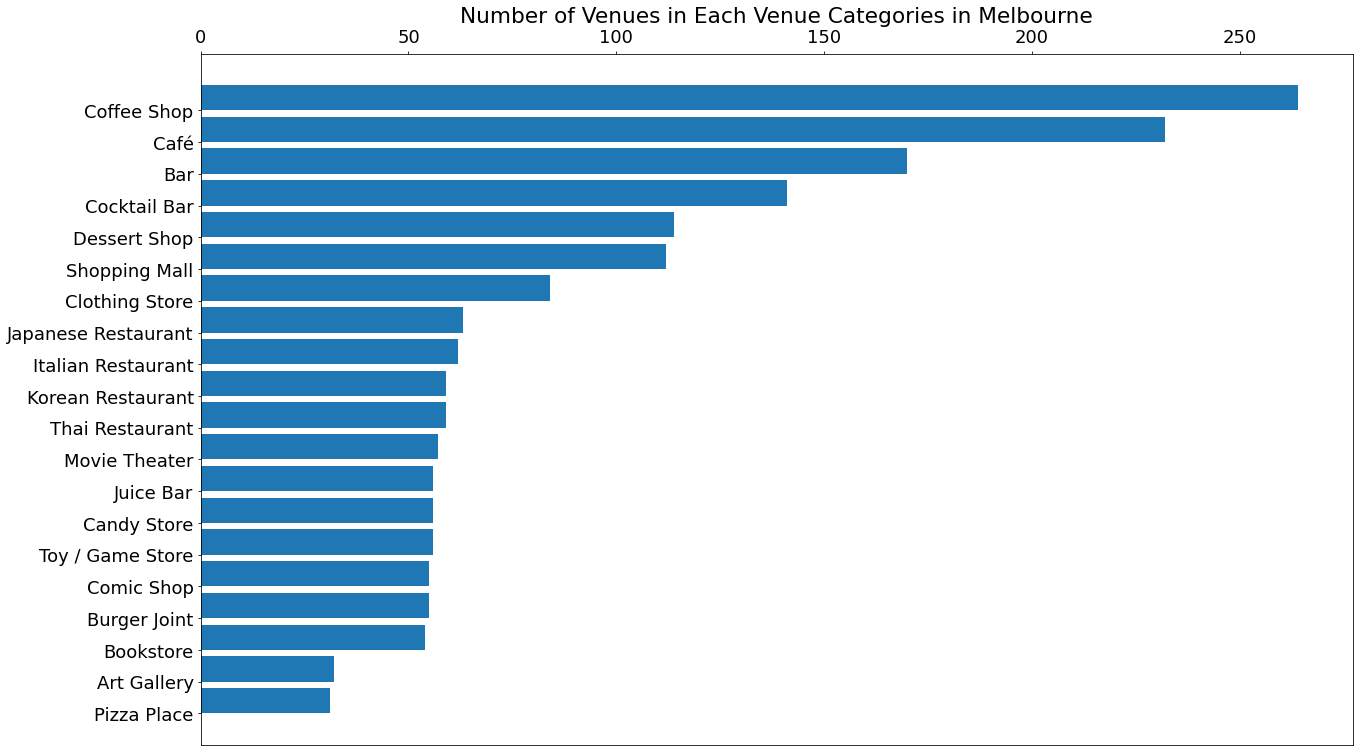

In [290]:
fig= plt.figure(figsize=(20,12))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.title('Number of Venues in Each Venue Categories in Melbourne') # add title to the plot 
plt.barh(venue_cate.index, venue_cate['Venue'], align='edge') 
plt.rc('font', size=18)
plt.gca().xaxis.tick_top()
plt.show()

Let's also print the top 18 venue categories in each neighborhood

In [236]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="") 
onehot['Neighborhood'] = venues['Neighborhood']   
grouped = onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 18
for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Collins Street West - 8007----
                 venue  freq
0          Coffee Shop  0.11
1                Hotel  0.08
2                 Café  0.07
3   Italian Restaurant  0.07
4         Cocktail Bar  0.07
5       Sandwich Place  0.03
6               Garden  0.03
7   Mexican Restaurant  0.03
8                 Park  0.03
9    French Restaurant  0.03
10         Art Gallery  0.03
11    Asian Restaurant  0.03
12                 Bar  0.03
13    Sushi Restaurant  0.02
14      Tennis Stadium  0.02
15           Hotel Bar  0.02
16   Indian Restaurant  0.02
17          Waterfront  0.02


----East Melbourne - 8002----
                            venue  freq
0                            Café  0.22
1                 Thai Restaurant  0.09
2                  Breakfast Spot  0.09
3             Japanese Restaurant  0.04
4               Convenience Store  0.04
5   Vegetarian / Vegan Restaurant  0.04
6                   Train Station  0.04
7                      Steakhouse  0.04
8                     

We will put the top venue categories into dataframe

In [286]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False) 
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 18 
indicators = ['st', 'nd', 'rd'] 
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue
0,Collins Street West - 8007,Coffee Shop,Hotel,Café,Cocktail Bar,Italian Restaurant,French Restaurant,Sandwich Place,Art Gallery,Asian Restaurant,Park,Bar,Mexican Restaurant,Garden,Indian Restaurant,Music Venue,Movie Theater,Wine Bar,Hotel Bar
1,East Melbourne - 8002,Café,Breakfast Spot,Thai Restaurant,Wine Bar,Steakhouse,Convenience Store,Cosmetics Shop,Indian Restaurant,Italian Restaurant,Museum,Park,Platform,Pub,Stadium,Japanese Restaurant,Vegetarian / Vegan Restaurant,Train Station,Sushi Restaurant
2,Melbourne - 3000,Café,Coffee Shop,Bar,Korean Restaurant,Dessert Shop,Japanese Restaurant,Shopping Mall,Clothing Store,Italian Restaurant,Toy / Game Store,Dim Sum Restaurant,Gym,Cosmetics Shop,Mexican Restaurant,Cocktail Bar,Candy Store,Thai Restaurant,Movie Theater
3,Melbourne - 3001,Coffee Shop,Café,Bar,Cocktail Bar,Dessert Shop,Shopping Mall,Clothing Store,Burger Joint,Juice Bar,Movie Theater,Italian Restaurant,Comic Shop,Candy Store,Japanese Restaurant,Korean Restaurant,Thai Restaurant,Bookstore,Toy / Game Store
4,Melbourne - 3004,Café,Hotel,Portuguese Restaurant,Sushi Restaurant,Park,Indian Restaurant,Salad Place,Chinese Restaurant,Pizza Place,Convenience Store,Gym,Indonesian Restaurant,Vietnamese Restaurant,Australian Restaurant,Department Store,Cosmetics Shop,Creperie,Cupcake Shop


Create a dataframe for each neighborhood showing how many venues it has for all venue categories

In [369]:
venue_all=venues.groupby(by=['Neighborhood','Venue Category']).agg(['count']) 
venue_all.columns= ['Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude']
venue_all=venue_all.reset_index(level='Venue Category',drop=False)
venue_all=venue_all.reset_index(drop=False)
venue_all.drop(columns=['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude'],inplace=True)
venue_all=venue_all.pivot(index='Neighborhood', columns="Venue Category", values='Venue').fillna(0)
venue_all.head()

Venue Category,Antique Shop,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Garden,...,Theater,Theme Park,Toy / Game Store,Train,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Collins Street West - 8007,0.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
East Melbourne - 8002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
Melbourne - 3000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
Melbourne - 3001,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,6.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Melbourne - 3004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Cluster neighborhoods by K-Nearest Neighbors

In [ ]:
# set number of clusters
kclusters = 5
venue_grouped_clustering = venue_all.reset_index(drop=True)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_all)
 
# add clustering labels
venue_all.insert(0, 'Cluster Labels', kmeans.labels_)

In [398]:
# Merge the cluster labels with venues, and geographic coordiantes

merged = venue_all.merge(df,left_on=venue_all.index,right_on="Neighborhood").set_index('Neighborhood')
merged.shape

(33, 104)

In [405]:
# create map
latitude = -37.8142176 
longitude = 144.9631608 

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = [] 
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged.index, merged['Cluster Labels']): 
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, 
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [383]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
# for lat, lng, label in zip(dataframe_filtered['location.lat'], dataframe_filtered['location.lng'], dataframe_filter)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

NameError: name 'dataframe_filtered' is not defined